In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
#from source.utils import *
from source.classes import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

# Set up and design project

In [3]:
with open('../../Desktop/DLC_social_1/DLC_social_1_exp_conditions.pickle', 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [4]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [5]:
%%time
DLC_social_1 = project(path='../../Desktop/DLC_social_1/',#Path where to find the required files
                   smooth_alpha=0.15,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego='B_Center',
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   video_format='.mp4',
                   table_format='.h5',
                   exp_conditions=Treatment_dict)

CPU times: user 2.63 s, sys: 744 ms, total: 3.38 s
Wall time: 1.14 s


# Run project

In [6]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)
print(DLC_social_1_coords)
type(DLC_social_1_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
Coordinates of 47 videos across 4 conditions
CPU times: user 9.39 s, sys: 683 ms, total: 10.1 s
Wall time: 10.4 s


source.classes.coordinates

# Generate coords

In [7]:
%%time
ptest = DLC_social_1_coords.get_coords(center=True, polar=False, speed=0)
ptest._type

CPU times: user 1.05 s, sys: 78 ms, total: 1.12 s
Wall time: 1.07 s


'coords'

In [8]:
%%time
dtest = DLC_social_1_coords.get_distances(speed=0)
dtest._type

CPU times: user 27.5 ms, sys: 12.7 ms, total: 40.2 ms
Wall time: 39.5 ms


'dists'

In [9]:
%%time
atest = DLC_social_1_coords.get_angles(degrees=True, speed=0)
atest._type

CPU times: user 124 ms, sys: 64.7 ms, total: 189 ms
Wall time: 188 ms


'angles'

# Visualization playground

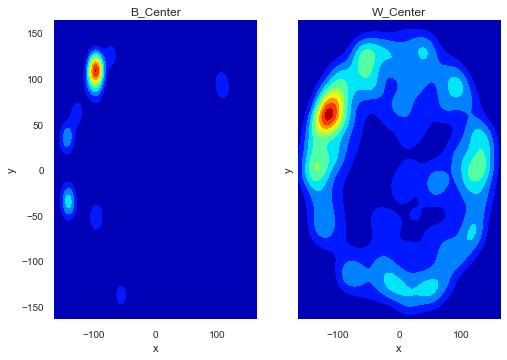

In [10]:
ptest.plot_heatmaps(['B_Center', 'W_Center'], i=1)

# Dimensionality reduction playground

In [11]:
pca = ptest.pca(4, 1000)

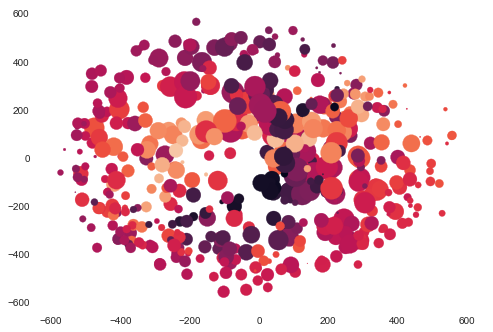

In [12]:
plt.scatter(*pca[0].T)
plt.show()

# Preprocessing playground

In [13]:
#Merging table_dict class

In [14]:
mtest = merge_tables(DLC_social_1_coords.get_coords(center=True, polar=True),
                 DLC_social_1_coords.get_distances(speed=0),
                 DLC_social_1_coords.get_angles(degrees=True, speed=2))

In [15]:
ptest = mtest.preprocess(window_size=51, filter='gaussian', sigma=10)

In [ ]:
etest = mtest.preprocess(window_size=51, filter='exponential', l=-1)

[1.00000000e+00 2.71828183e+00 7.38905610e+00 2.00855369e+01
 5.45981500e+01 1.48413159e+02 4.03428793e+02 1.09663316e+03
 2.98095799e+03 8.10308393e+03 2.20264658e+04 5.98741417e+04
 1.62754791e+05 4.42413392e+05 1.20260428e+06 3.26901737e+06
 8.88611052e+06 2.41549528e+07 6.56599691e+07 1.78482301e+08
 4.85165195e+08 1.31881573e+09 3.58491285e+09 9.74480345e+09
 2.64891221e+10 7.20048993e+10 1.95729609e+11 5.32048241e+11
 1.44625706e+12 3.93133430e+12 1.06864746e+13 2.90488497e+13
 7.89629602e+13 2.14643580e+14 5.83461743e+14 1.58601345e+15
 4.31123155e+15 1.17191424e+16 3.18559318e+16 8.65934004e+16
 2.35385267e+17 6.39843494e+17 1.73927494e+18 4.72783947e+18
 1.28516001e+19 3.49342711e+19 9.49611942e+19 2.58131289e+20
 7.01673591e+20 1.90734657e+21 5.18470553e+21]


In [17]:
ttest = mtest.preprocess(window_size=51, filter=None)

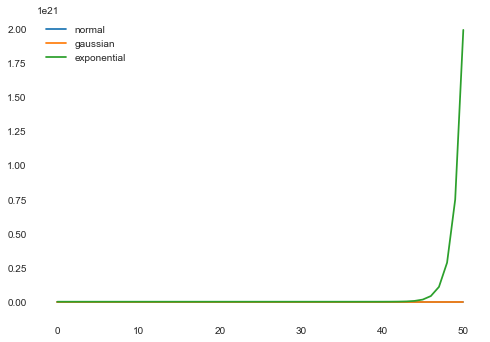

In [20]:
plt.plot(ttest[2,:,2], label='normal')
plt.plot(ptest[2,:,2], label='gaussian')
plt.plot(etest[2,:,2], label='exponential')
plt.legend()
plt.show()